In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from CoinToss import CoinTossSimple
from collections import deque
from stable_baselines3 import PPO

# Hyperparameters and functions

In [2]:
# hyperparameters
N_STEP        = 200           # multi-step TD
GAMMA         = 0.9
LR            = 0.1
EPS_START     = 1.0
EPS_END       = 0.001
EPS_DECAY     = 0.9
EPISODES      = 3000
# discrete action space
ACTION_SPACE = np.arange(0.05, 1, 0.1)  #[0.05  0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
ACTION_BINS = len(ACTION_SPACE)
CLIP_LOW      = 1e-10
CLIP_HIGH     = 0.99999

In [20]:
def epsilon_greedy_action(state, Q_function, epsilon):
    if np.random.rand() < epsilon:
        a_index = np.random.randint(ACTION_BINS)
    else:
        max_indices = np.where(Q_function[state] == np.max(Q_function[state]))[0]
        a_index = np.random.choice(max_indices)
    return a_index

def modified_GM(x, n):
    magnitude = abs(x) ** (1. / n)
    if x >= 0: return magnitude
    return -1 * magnitude

def evaluate_policy(environment, Q_eva, episodes):
    """ evaluate current policy, return the mean/median value of testing results, and plot the first ten trajectories """
    returns, wealth_traj = [], []
    for _ in range(episodes):
        state, _ = environment.reset()
        environment.max_episode_steps = 100
        done = False
        total = environment.cum_reward
        traj = [environment.cum_reward]
        while not done:
            a_idx = int(np.argmax(Q_eva[state]))
            action = ACTION_SPACE[a_idx]
            state, r, done, _, info = environment.step(np.array([action], dtype=np.float32))
            total = environment.cum_reward
            traj.append(info["wealth"])
        returns.append(total)
        wealth_traj.append(traj)

    returns = np.array(returns, dtype=np.float32)
    print(f"[Eval] mean={returns.mean():.3f} | median={np.median(returns):.3f} | std={returns.std():.3f}")
    plt.figure(figsize=(5,3))
    for i in range(min(10, len(wealth_traj))):
        plt.plot(wealth_traj[i], label=f"Traj {i+1}")
    plt.xlabel("Step")
    plt.ylabel("Wealth")
    plt.title("Wealth trajectory (sample)")
    plt.grid(alpha=0.3)
    plt.show()
    return returns

# 1. standard multi-step Q learning for training, and policy evaluation

Training:   0%|          | 1/3000 [00:00<18:14,  2.74it/s]

Episode 0, Total Reward: 3.390889502786692e-10, Epsilon: 0.9000
1 8


Training:  17%|█▋        | 502/3000 [03:49<19:32,  2.13it/s]

Episode 500, Total Reward: 5.54852972818878e-07, Epsilon: 0.0046
3 4


Training:  33%|███▎      | 1001/3000 [07:45<15:25,  2.16it/s]

Episode 1000, Total Reward: 1.465977562324906e-09, Epsilon: 0.0010
7 6


Training:  50%|█████     | 1501/3000 [11:37<11:32,  2.16it/s]

Episode 1500, Total Reward: 7.449055992881569e-10, Epsilon: 0.0010
8 2


Training:  67%|██████▋   | 2001/3000 [15:29<07:41,  2.16it/s]

Episode 2000, Total Reward: 2.0584031265094748e-09, Epsilon: 0.0010
9 1


Training:  83%|████████▎ | 2502/3000 [19:23<03:55,  2.12it/s]

Episode 2500, Total Reward: 1.620502039331157e-10, Epsilon: 0.0010
9 2


Training: 100%|██████████| 3000/3000 [23:19<00:00,  2.14it/s]


7 6


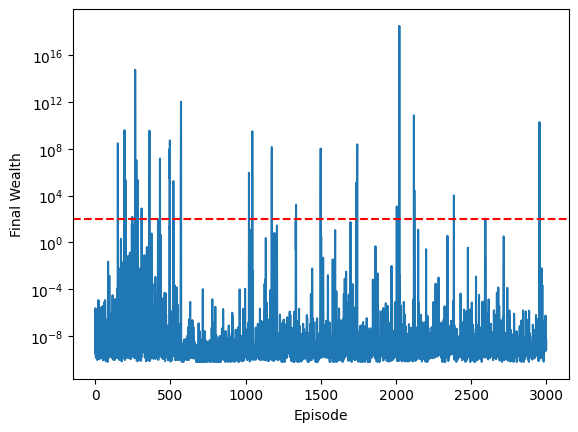

'\nplt.figure(figsize=(6, 3))\nplt.plot(returns_log, marker=\'o\', markersize=3, alpha=0.6)\nplt.axhline(y=R_0, color=\'r\', linestyle=\'--\')\nplt.xlabel("Episode")\nplt.ylabel("Final Wealth")\nplt.yscale(\'log\')\nplt.title("Final wealth per episode")\nplt.grid(alpha=0.3)\nplt.show()\n'

In [4]:
# training
env_multi_Q = CoinTossSimple()
R_0 = env_multi_Q.initial_wealth
epsilon = EPS_START
returns_log = []            # record of the terminated wealth
Q_multi = np.zeros((2, ACTION_BINS), dtype=np.float32)

for episode in trange(EPISODES, desc="Training"):
    state, _ = env_multi_Q.reset()
    done = False
    total_reward = env_multi_Q.initial_wealth

    # multi-step buffer
    buffer = deque(maxlen=N_STEP)

    while not done:
        a_idx = epsilon_greedy_action(state, Q_multi, epsilon)
        action = ACTION_SPACE[a_idx]

        next_state, r, done, _, info = env_multi_Q.step(np.array([action], dtype=np.float32))

        buffer.append((state, a_idx, r))
        total_reward = env_multi_Q.cum_reward

        if len(buffer) == N_STEP:
            G = 0.0
            for i in range(N_STEP):
                G += (GAMMA ** i) * buffer[i][2]

            if not done:
                G += (GAMMA ** N_STEP) * np.max(Q_multi[next_state])

            s_tau, a_tau, _ = buffer.popleft()
            td_error = G - Q_multi[s_tau, a_tau]
            Q_multi[s_tau, a_tau] += LR * td_error

        state = next_state

    # after episode, clear the buffer
    while len(buffer) > 0:
        horizon = len(buffer)
        G = 0.0
        for i in range(horizon):
            G += (GAMMA ** i) * buffer[i][2]
        s_tau, a_tau, _ = buffer.popleft()
        td_error = G - Q_multi[s_tau, a_tau]
        Q_multi[s_tau, a_tau] += LR * td_error

    returns_log.append(total_reward)

    # epsilon decay
    if episode % 10 == 0:
        if epsilon > EPS_END:
            epsilon = max(EPS_END, epsilon * EPS_DECAY)
        if episode % 500 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")
            print( np.argmax(Q_multi[0,:]),np.argmax(Q_multi[1,:]) )


print( np.argmax(Q_multi[0,:]),np.argmax(Q_multi[1,:]) )
plt.plot(returns_log)
plt.axhline(y=R_0, color='r', linestyle='--')
plt.xlabel("Episode")
plt.ylabel("Final Wealth")
plt.yscale('log')
plt.show()


[Eval] mean=2595.547 | median=27.526 | std=21360.064


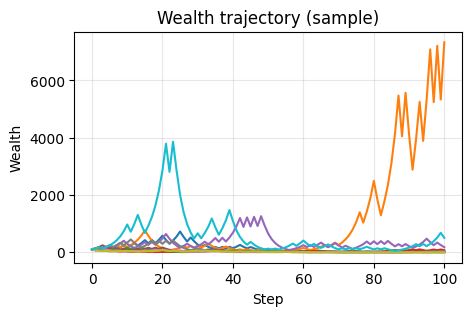

In [21]:
# policy evaluation
TEST_ENV = CoinTossSimple()
_ = evaluate_policy(TEST_ENV, Q_multi, episodes=100)

# 2. modified GM multi-step Q leanring for training, and policy evaluation (our approach)

  0%|          | 4/3000 [00:00<04:35, 10.89it/s]

Episode 0, Total Reward: 4.6496461252982243e-10, Epsilon: 0.9000
9 3


 17%|█▋        | 502/3000 [01:16<06:57,  5.98it/s]

Episode 500, Total Reward: 4.912498600206546e+22, Epsilon: 0.0046
1 1


 33%|███▎      | 1003/3000 [02:41<05:30,  6.05it/s]

Episode 1000, Total Reward: 8.160600925620959e+20, Epsilon: 0.0010
0 1


 50%|█████     | 1502/3000 [04:04<04:07,  6.04it/s]

Episode 1500, Total Reward: 53740234287821.71, Epsilon: 0.0010
0 0


 67%|██████▋   | 2003/3000 [05:28<02:47,  5.95it/s]

Episode 2000, Total Reward: 1.8261887010277523e+25, Epsilon: 0.0010
2 2


 83%|████████▎ | 2503/3000 [06:51<01:23,  5.99it/s]

Episode 2500, Total Reward: 4.706181072627069e+23, Epsilon: 0.0010
2 1


100%|██████████| 3000/3000 [08:14<00:00,  6.06it/s]


0 0


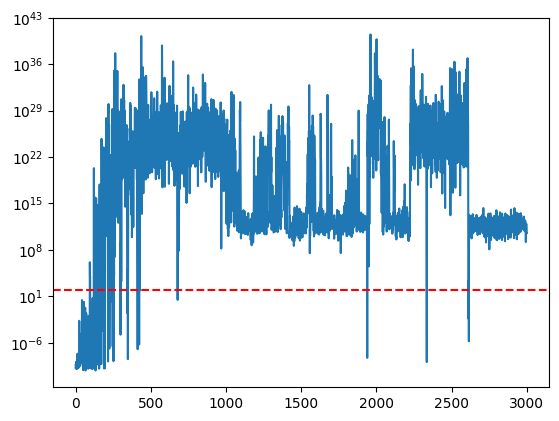

In [17]:
LAMBDA = 1
env_gm_multi_q = CoinTossSimple()
R_0 = env_gm_multi_q.initial_wealth
epsilon = EPS_START
Q_gm = np.zeros(( 2,ACTION_BINS ))
rewards_episodes = []

for episode in trange(EPISODES):
    #state = env.reset()
    state,_ = env_gm_multi_q.reset()

    buffer = deque(maxlen=N_STEP )
    total_reward = env_gm_multi_q.initial_wealth #env.initial wealth
    done = False

    while not done:
        action_index = epsilon_greedy_action(state, Q_gm, epsilon)
        action = ACTION_SPACE[action_index]

        state, reward, done, _, _ = env_gm_multi_q.step(action)
        buffer.append( (state, action_index , reward) )

        total_reward = env_gm_multi_q.cum_reward

        G = 0.0
        if len(buffer) == N_STEP :
            delta = modified_GM( sum(buffer[i][2] for i in range(N_STEP ) ), N_STEP  )

            G = sum(  [GAMMA ** i * buffer[i][2] for i in range(N_STEP )]  )
            G = (1-LAMBDA) * G + LAMBDA * delta * (1-GAMMA**N_STEP )

            G += GAMMA ** N_STEP  * np.max(Q_gm[state])
            s_tau, a_tau_index,_ = buffer[0]
            Q_gm[s_tau,a_tau_index] += LR * (G - Q_gm[ s_tau,a_tau_index ])
            buffer.clear()



    # epsilon decay
    if episode % 10 == 0:
        if epsilon > EPS_END:
            epsilon = max(EPS_END, epsilon * EPS_DECAY)
        if episode % 500 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")
            print( np.argmax(Q_gm[0,:]),np.argmax(Q_gm[1,:]) )

    rewards_episodes.append(total_reward)


print( np.argmax(Q_gm[0,:]),np.argmax(Q_gm[1,:]) )

plt.plot(rewards_episodes)
plt.axhline(y=R_0, color='r', linestyle='--')
plt.yscale('log')
plt.show()

[Eval] mean=132.028 | median=125.169 | std=32.209


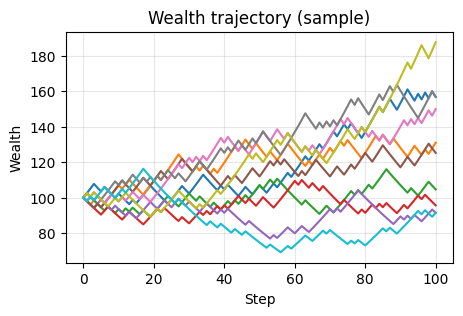

In [22]:
TEST_ENV_2 = CoinTossSimple()
_ = evaluate_policy(TEST_ENV_2, Q_gm, episodes=100)

# 3. PPO algorithm for training and policy evaluation

In [24]:
# training process
env1 = CoinTossSimple()
num_time_steps = 3000
model = PPO('MlpPolicy', env1, verbose=1)
model.learn(total_timesteps=num_time_steps, progress_bar=True)
model.save("ppo_coin_toss")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/shengx1/Library/Python/3.9/lib/python/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

-----------------------------
| time/              |      |
|    fps             | 7163 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 4576         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0009254315 |
|    clip_fraction        | 0.00356      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.000202     |
|    learning_rate        | 0.0003       |
|    loss                 | 86.1         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000371    |
|    std                  | 0.986        |
|    value_loss           | 189          |
----------------

In [27]:
# policy evaluation
game_standard = CoinTossSimple()
num_exp = 100
ep_len = 100

traj_standard = np.zeros((num_exp, ep_len + 1))

for idx_1 in range(num_exp):
    obs_standard, info = game_standard.reset()
    traj_standard[idx_1, 0] = 100
    action_standard, _ = model.predict(obs_standard)
    for idx_2 in range(ep_len):

        obs_standard, rew_standard, _, _, _ = game_standard.step(action_standard)
        action_standard, _ = model.predict(obs_standard)
        traj_standard[idx_1, idx_2 + 1] = game_standard.cum_reward.item()

print(f"[Eval] mean={np.mean(traj_standard[:, -1]):.3f} | median={np.median(traj_standard[:, -1]):.3f} | std={np.std(traj_standard[:, -1]):.3f}")


[Eval] mean=352.839 | median=39.032 | std=1940.731


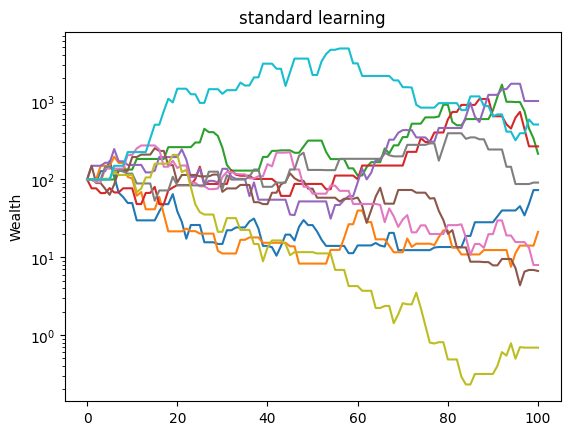

In [28]:
# visualization for the first 10 trajectories
plt.plot()
plt.plot(traj_standard[0:10, :].T)
plt.title('standard learning')
plt.ylabel("Wealth")
plt.yscale('log')
plt.show()